In [1]:
#Building makemore Part 3: Activations & Gradients, BatchNorm(https://youtu.be/P6sfmUTpUmc?si=Q5mgzxg49be-SR1L)

In [2]:
import torch
import torch.nn.functional as F

#draw the plot outside results
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
words = open('names.txt', 'r').read().split()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
chars = ['.'] + [chr(i + ord('a')) for i in range(26)]
stoi = {s:i for i,s in enumerate(chars)}
itos = {stoi[v]:v for v in stoi}

In [5]:
import random

def crete_training_data(words, context_length):
    xs = []
    ys = []
    for w in words:
        #print(w)
        context = [stoi['.']]*context_length
        for ch in w + '.':
            ix = stoi[ch]
            xs.append(context)
            ys.append(ix)
            #print(f'{''.join([itos[i] for i in context])} -> {itos[ix]}')
            context = context[1:] + [ix] # rolling window
    return torch.tensor(xs), torch.tensor(ys)

def crete_training_data_with_split(words, context_length, selection_randomization_seed, test_spilit=(0.8,0.1,0.1)):
    random.seed(selection_randomization_seed)
    random.shuffle(words)
    outs = []

    sum_for_test_split = sum(s for s in test_spilit)
    normalized_test_split = [s/sum_for_test_split for s in test_spilit]
    last_start = 0
    for i,s in enumerate(normalized_test_split):
        start = last_start
        if i > 0:
            start += int(normalized_test_split[i - 1] * len(words))
        last_start = start
        end = start + int(s * len(words))
        if i + 1 == len(normalized_test_split):
            end = len(words)
        #print(start,end,len(words))
        xs,ys = crete_training_data(words[start:end],context_length)
        outs.append((xs,ys))
    return outs

In [6]:
data_spilit=(0.8,0.1,0.1)
training_data = crete_training_data_with_split(words, 3, 42, data_spilit)
Xtr,Ytr = training_data[0]
Xdev,Ydev = training_data[1]
Xte,Yte = training_data[2]

print(f'training data size = {Xtr.shape[0]}, input size ={int(len(words) * data_spilit[0])}')
print(f'dev data size = {Xdev.shape[0]}, input size ={int(len(words) * data_spilit[1])}')
print(f'dev data size = {Xte.shape[0]}, input size ={int(len(words) * data_spilit[2])}')

training data size = 182625, input size =25626
dev data size = 22655, input size =3203
dev data size = 22866, input size =3203


In [7]:
#remember if we represent a layer as a matrix we consider every row to be a neuron so we can apply them as x @ matrix so on the columns we have all the waits for a given input

#cleand-up version
def create_concrete_training_data(embading_size):
    words = open('names.txt', 'r').read().split()
    return crete_traininng_data(words, embading_size)

def crate_model_parameters(alphabet_size, num_embading_dimensions, embading_size, number_of_neurons_in_the_hiden_layer, generator_seed):
    #the input space is the same as the output space and the same as the alphabet
    
    #rng for consistency
    g = torch.Generator().manual_seed(generator_seed)

    #we have 27 characters, this is our output space as such we expect the initial loss to be
    #-torch.tensor(1.0/27.0).log()
    #tensor(3.2958)
    #because our initial loss is very big we will try to decrese the values for the initial parameters
    #the hokey stick look is *bad* it means that in the first iterations you are just wasteing time ! as such we should decrese the initialization params
    
    #embading space
    C = torch.randn((alphabet_size, num_embading_dimensions), generator=g)
    #hiden layer
    #initial standard deviation * specific deviation correction for tanh / fan in (square root of the number of columns)
    w1_correction = 1.0 * ((3/5) /  (num_embading_dimensions * embading_size)**0.5)
    W1 = torch.randn((num_embading_dimensions * embading_size, number_of_neurons_in_the_hiden_layer), generator=g) * w1_correction #set because we don't like the output of h when we forward the model
    # see the loss calculation b1 = torch.randn(number_of_neurons_in_the_hiden_layer, generator=g) * 0.0001 #set because we don't like the output of h when we forward the model

    #output layer
    w2_correction = 1.0 * ((3/5) /  (number_of_neurons_in_the_hiden_layer)**0.5)
    W2 = torch.randn((number_of_neurons_in_the_hiden_layer, alphabet_size), generator=g) * w2_correction #set because we don't like the initial lose
    b2 = torch.randn(alphabet_size, generator=g) * 0.0001 #set because we don't like the initial lose

    bngain = torch.ones((1, number_of_hiden_nerons))
    bnbias = torch.zeros((1, number_of_hiden_nerons))

    params = (g, C, W1, W2, b2, bngain, bnbias)

    #torch has a magical nature, if you mark a tensor with requires_grad then you can't do this for any of the tensors derived from it.
    #better to set this on all the elements that are part of the model at the end of the initialization.
    for p in params[1:]:
        p.requires_grad = True
        
    return params

def forward(parameters, xs, num_embading_dimensions, embading_size, mean , std, bias):
    g, C, W1, W2, b2, bngain, bnbias = parameters
    #embade xs in C
    emb = C[xs]
    
    #apply the hiden layer

    embcat = emb.view(-1, num_embading_dimensions * embading_size)
    hpreact = embcat @ W1 #+ b1 see calculate_loss
    hpreact = (bngain * ((hpreact - mean) / (std + bias))) + bnbias
    
    h = torch.tanh(hpreact)
    
    #apply the output layer
    logits = h @ W2 + b2
    
    #soft max
    #counts = logits.exp()
    #prob = counts / counts.sum(1, keepdim=True)
    prob = F.softmax(logits, dim=1)

    return prob

def calculate_loss(parameters, xs, ys, num_embading_dimensions, embading_size, bias, plot_h=False, mean=None, std=None):
    g, C, W1, W2, b2, bngain, bnbias = parameters
    #embade xs in C
    emb = C[xs] #embad the characters in to the vector space C
    embcat = emb.view(-1,num_embading_dimensions * embading_size) # view the embadings in a matrix where all the embading data is in the same row
    #apply the hiden layer
    hpreact = embcat @ W1 #+ b1 we removed this because of the batch normalization, at some point we substract the mean from the result so
                          #we cancel the efect of this term
                          #we also don't want to add it later because we now have bnbias

    #normalize the hiden layer state
    #because we will do a tanh on this after we want to have roughly a gausian shape for the data so we would always learn, 
    #we don't want to big or to small values so we won't be on the pateu of the tenh where the gradient is 0
    #we have bngain and bnbias as a trainable weight for this so the network can bias this so we won't go to a local maxima.
    #this helps a lot with the quality of the initial untrained weights.(basically you can skeep the stuff that we did in the scaling of the parameter generation)
    if mean == None and std == None:
        mean = hpreact.mean(0, keepdim=True)
        std = hpreact.std(0, keepdim=True)

    hpreact = (bngain * ((hpreact - mean) / (std + bias))) + bnbias

    h = torch.tanh(hpreact)

    
    if plot_h:
        # we have a lot of extreme values 1 or 0 because of the inputs for the tanh
        plt.hist(h.view(-1).tolist(), 50)
        plt.show()
        #this inputs are big in value as such the final results are 1 or 0
        plt.hist(hpreact.view(-1).tolist(), 50)
        plt.show()
        #we end up with *dead* neurons, every row is a neuron and if all the activiations for a given output are 1 there will never be significant output for that activation
        #if the value is 1 or -1 because of the tenh the derivative will be close to 0!!(see activation_functions.jpg) and think about what happenes if you are on the flat part
        #this is why we set the multipliers for the hiden layer W1,b1
        #this should not have columns of white, better if this has no white
        plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
        plt.show()
    
    #apply the output layer
    logits = h @ W2 + b2
    
    loss = F.cross_entropy(logits, ys)
    return loss, mean, std

@torch.no_grad()
def calibrate_after_mini_batch_normalization_end_of_training(parameters, xtr):
    g, C, W1, W2, b2, bngain, bnbias = parameters
    
    emb = C[xtr]
    embcat = emb.view(emb.shape[0], -1) # for every example one row
    hpreact = embcat @ W1 #+ b1 see calculate_loss
    mean_over_set = hpreact.mean(0, keepdim=True)
    standard_deviation_over_set = hpreact.std(0, keepdim=True)
    return (mean_over_set, standard_deviation_over_set)
    

In [8]:
embeding_size = 3
alphabet_size = 27
num_embading_dimensions = 2
number_of_hiden_nerons = 100
generator_seed = 214_748_364_7
learning_ratre = 1

#create model
parameters = crate_model_parameters(alphabet_size, num_embading_dimensions, embeding_size, number_of_hiden_nerons, generator_seed)
num_parameters = sum(p.nelement() for p in parameters[1:])
print(f'num parameters = {num_parameters}')

bnmean_running = torch.ones((1, number_of_hiden_nerons))
bnstd_running = torch.zeros((1, number_of_hiden_nerons))
bnstd_bias = torch.zeros((1, number_of_hiden_nerons)) * 0.00001

num parameters = 3581


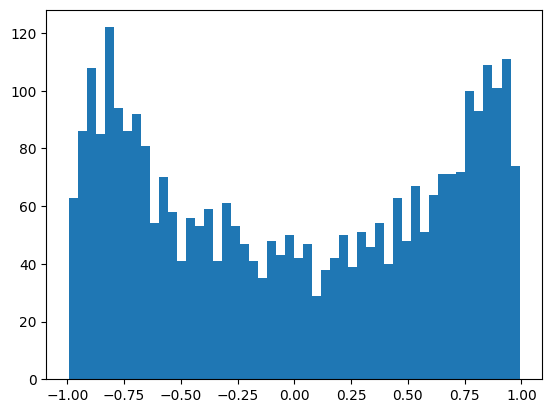

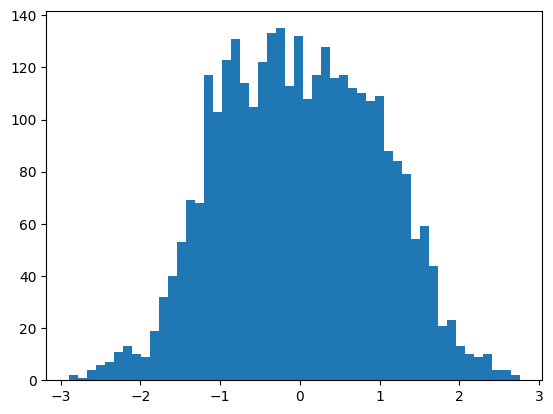

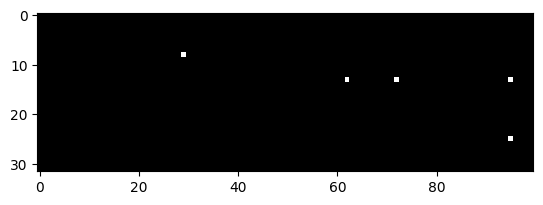

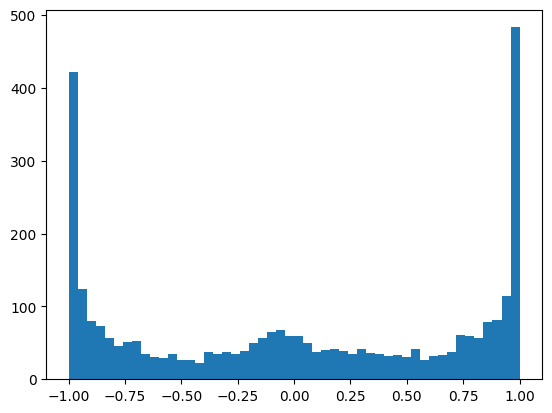

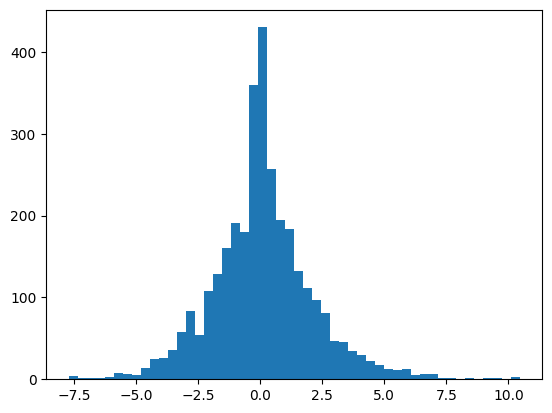

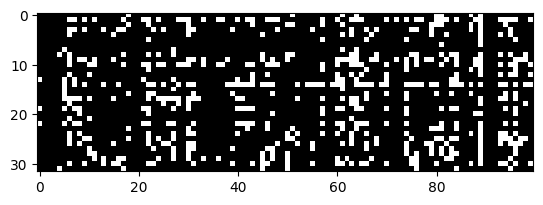

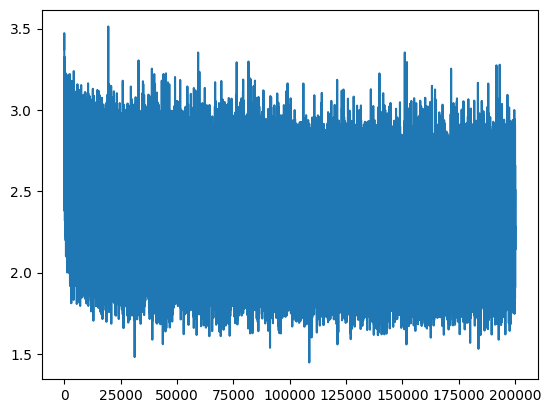

In [9]:
#training
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    ##mini batch
    batch_indexes = torch.randint(0, Xtr.shape[0], (batch_size,))
    local_xs = Xtr[batch_indexes]
    local_ys = Ytr[batch_indexes]
    
    ##forward
    loss, meani, stdi = calculate_loss(parameters, local_xs, local_ys, num_embading_dimensions, embeding_size, bnstd_bias, plot_h=True if i == 0 or (i + 1) == max_steps else False)
    lossi.append(loss.item())
    with torch.no_grad():
        bnmean_running = bnmean_running * 0.999 + meani * 0.001
        bnstd_running = bnstd_running * 0.999 + stdi * 0.001
    
    ##backward
    for p in parameters[1:]:
        p.grad = None
    loss.backward()

    ##update
    lr = -0.1 if i < 100000 else -0.01
    for p in parameters[1:]:
        p.data += lr * p.grad

plt.plot(lossi)
plt.show()

In [10]:
#calibrate because we used batch normalization
#stores_mean_and_deviation = calibrate_after_mini_batch_normalization_end_of_training(parameters, Xtr)

In [11]:
@torch.no_grad() # disable the calculation of gradients
def split_loss(split):
    x,y = {
        'train' : training_data[0],
        'val'   : training_data[1],
        'test'  : training_data[2],
    }[split]
    loss,_,_ = calculate_loss(parameters, x, y, num_embading_dimensions, embeding_size, bnstd_bias, mean=bnmean_running, std=bnstd_running)
    print(f'total loss on the {split} data = {loss.item()}')

split_loss('train')
split_loss('val')
split_loss('test')

total loss on the train data = 2.2360219955444336
total loss on the val data = 2.2399144172668457
total loss on the test data = 2.238222599029541


In [12]:
#use
g = torch.Generator().manual_seed(214_748_364_7 + 13)
for _ in range(10):
    ixs = [0] * embeding_size
    output = []
    while True:
        prob = forward(parameters, torch.tensor([ixs]), num_embading_dimensions, embeding_size, bnmean_running, bnstd_running, bnstd_bias)
        ix = torch.multinomial(prob, 1, True, generator=g).item()
        if ix == 0:
            break;
        ixs = ixs[1:] + [ix]
        #print(ixs)
        output.append(itos[ix])
    print(''.join(output))

lynn
jashani
thera
bry
eat
eldani
cuexery
bronn
mia
riannie
